#In this project we will attempt to classify tweets. More specifically, we will perform a sentiment analysis using Logistic Regression and KNN. The comparison of the results will be done with the use of a baseline classifier that will classify every tweet in the most frequent category.

In [177]:
!pip install -U scikit_learn
!pip install -U nltk
!pip install -U datasets
!pip install -U tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [178]:
from datasets import load_dataset
import numpy as np
import pandas as pd
import re
import time
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import random
import nltk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from nltk import sent_tokenize, word_tokenize, pos_tag
from pandas.core.missing import find_valid_index
from sklearn.model_selection import learning_curve, GridSearchCV
from tabulate import tabulate
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from google.colab import files
#uploaded = files.upload()
stemmer = WordNetLemmatizer()
warnings.filterwarnings("ignore")
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

###After importing everything we need for our model, we load the dataset and separate to train, dev and test. We also define a function that cuts a percentage of the data to save processing time

In [179]:
def remove(text, polarity, n):
    for _ in range(int(len(text)*n)):
        number = random.randrange(0,len(text))
        text.pop(number)
        polarity.pop(number)
    return

#importing the dataset
tweets = load_dataset("tweet_eval",'sentiment')


#create train/dev/test sets 
train = tweets['train']
dev = tweets['validation']
test = tweets['test']

x_train = train['text']
x_val = dev['text'] 
x_test = test['text']

y_train = train['label'] 
y_val = dev['label']
y_test = test['label']

print(len(x_train))
#removing big parts because of too many data
remove(x_train, y_train, 0.2)
print(len(x_train))
#remove(x_val, y_val, 0.5)
#remove(x_test, y_test, 0.5)


  0%|          | 0/3 [00:00<?, ?it/s]

45615
36492


###This part was supposed to be creating a function that locates all the emojis used in the tweets and convert them to their word versions. But it seems that the data are cleaned from emojis so it is not usefull anymore. I chose to leave it here if anyone was interested in the emoji extraction method.

In [180]:
#def convert_emojis_to_word(text):
#    for emot in Emoji_Dict:
#        text = re.sub(r'('+emot+')', "_".join(Emoji_Dict[emot].replace(",", "-").replace(":", "-").split()), text)
#        text = text.replace("-", " ")
#    return text


#with open('/content/Emoji_Dict.p', 'rb') as fp:
#    Emoji_Dict = pickle.load(fp)
#Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}


###Subsequently, we preprocess the data. We create a function that takes the according dataset as input and makes the necessary adjustments.

In [181]:
def preProcess(x):
  document = []
  counter1 = 0
  for row in x:
      document.append(x[counter1])
      counter1 += 1

  counter = 0
  for i in document:
      # Extract text from Emojis and Emoticons
      #document[counter] = convert_emojis_to_word(i)

      # Remove non-word (special) characters such as punctuation, numbers etc
      document[counter] = re.sub(r'\W', ' ', document[counter])

      # Remove all single characters
      document[counter] = re.sub(r'\s+[a-zA-Z]\s+', ' ', document[counter])

      # Substitute multiple spaces with single space
      document[counter] = re.sub(r'\s+', ' ', document[counter], flags=re.I)

      # Convert to Lowercase
      document[counter] = document[counter].lower()

      # Split the document based on whitespaces (--> List of words)
      document[counter] = document[counter].split()

      # Lemmatization
      document[counter] = [stemmer.lemmatize(word) for word in document[counter]]

      # Reconstruct the document by joining the words on each whitespace
      document[counter] = ' '.join(document[counter])
      x[counter] = document[counter]
      counter += 1

  return x


x_train = preProcess(x_train)
x_val = preProcess(x_val)
x_test = preProcess(x_test)

###Next, we perform dimensionality reduction and we extract the features based on which KNN and Logistic Regression will classify.

In [182]:
# Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(
    ngram_range = (1, 3),
    max_features = 10000,
    #min_df = 0.005,
    #max_df = 0.7,
    # Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf).
    sublinear_tf = True,
    stop_words = stopwords.words('english'))

# Fit Vectorizer on train data
# Transform on all data (train - test)
x_train_tfidf = vectorizer.fit_transform(x_train)
x_val_tfidf = vectorizer.transform(x_val)
x_test_tfidf = vectorizer.transform(x_test)

print(vectorizer.get_feature_names())
print('Shape of training data: {}'.format(x_train_tfidf.shape))
print('Shape of evaluation data: {}\n'.format(x_val_tfidf.shape))
print('Shape of test data: {}\n'.format(x_test_tfidf.shape))

print(x_val_tfidf[0, :])  # Sparce matrix --> Saves only the cells which are not zero

['00', '00 pm', '000', '00am', '00pm', '01', '02', '03', '039', '04', '05', '06', '07', '08', '09', '10', '10 11', '10 30', '10 day', '10 min', '10 minute', '10 year', '100', '1000', '100th', '101', '10am', '10pm', '10th', '10th amendment', '10th anniversary', '10th grade', '10th time', '11', '11 00', '11 30', '11am', '11pm', '11th', '12', '12 00', '12 12', '120', '12pm', '12th', '13', '13th', '14', '14th', '14th amendment', '14th anniversary', '15', '15 day', '15 minute', '150', '15th', '15th birthday', '16', '16 august', '160', '16th', '16th birthday', '16th time', '17', '17th', '18', '18th', '18th birthday', '19', '1967', '1967 1993', '1971', '1987', '1993', '1994', '1995', '19th', '19th national', '19th national ice', '1d', '1pm', '1st', '1st 10', '1st 2nd', '1st album', '1st amendment', '1st amp', '1st anniversary', '1st choice', '1st class', '1st day', '1st day school', '1st debate', '1st episode', '1st ever', '1st game', '1st gen', '1st goal', '1st half', '1st hole', '1st lady',

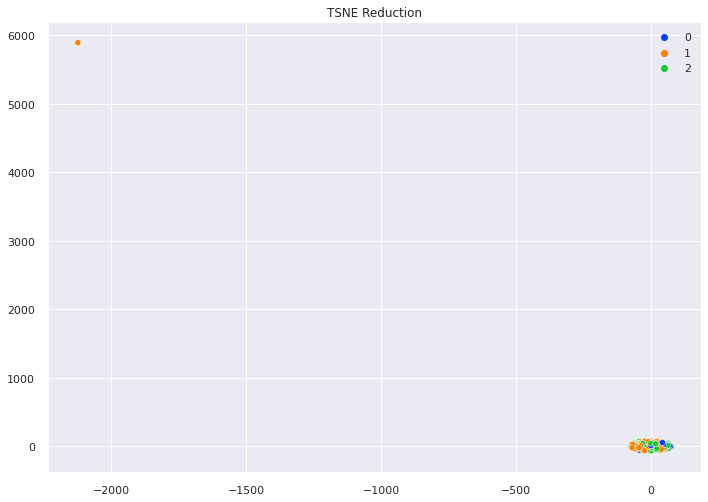

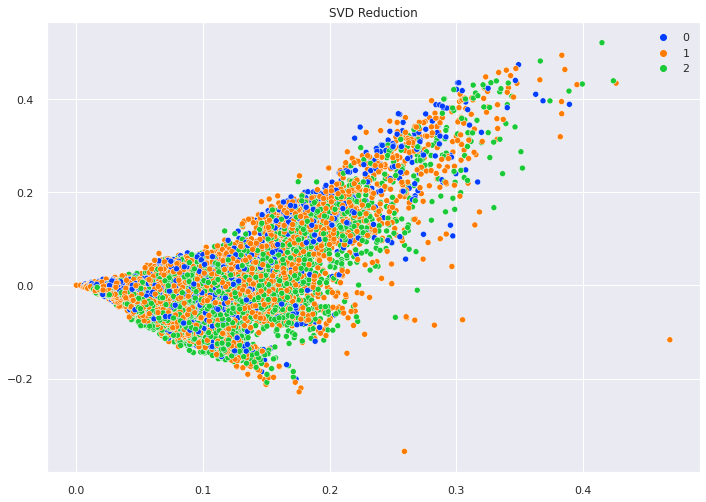

In [183]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 3)

# Dimensionality reduction using TSNE
tsne = TSNE(n_components=2, random_state=4321)
x_train_trunc = tsne.fit_transform(x_train_tfidf)

plt.figure()
plt.title('TSNE Reduction')
sns.scatterplot(x=x_train_trunc[:, 0], y=x_train_trunc[:, 1], hue=y_train, legend='full', palette=palette)
plt.show(block= False)

# Dimensionality Reduction using SVD
svd = TruncatedSVD(n_components=2, random_state=4321)
x_train_trunc = svd.fit_transform(x_train_tfidf)

plt.figure()
plt.title('SVD Reduction')
sns.scatterplot(x=x_train_trunc[:, 0], y=x_train_trunc[:, 1], hue=y_train, legend='full', palette=palette)
plt.show(block=False)


In [184]:
# Number of features to keep
k = 3000

# Convert sparse matrix to np.array --> Slow
x_train_tfidf_array = x_train_tfidf.toarray()

# The function relies on nonparametric methods
# based on entropy estimation from k-nearest neighbors distances
mutual_information = mutual_info_classif(x_train_tfidf_array, y_train, n_neighbors=5,
                                         discrete_features=True,
                                         random_state=4321)

# Indexes of the feature columns
indexes = np.arange(len(mutual_information))

# Sort by mutual information values --> (value, idx)
sorted_indexes = sorted(zip(mutual_information, indexes), reverse=True)
print('Sorted indexes: {}'.format(sorted_indexes[:4]))

# keep the indexes of the best k features
best_idxs = [idx for val, idx in sorted_indexes[:k]]
print('Best indexes: {}\n'.format(best_idxs[:4]))

# Keep only the columns of the best features
x_train_best_tfidf = x_train_tfidf_array[:, best_idxs]
x_val_best_tfidf = x_val_tfidf[:, best_idxs]
x_test_best_tfidf = x_test_tfidf[:, best_idxs]

print('Shape of training data: {} --> {}'.format(x_train_tfidf.shape, x_train_best_tfidf.shape))
print('Shape of evaluation data: {} --> {}\n'.format(x_val_tfidf.shape, x_val_best_tfidf.shape))
print('Shape of test data: {} --> {}\n'.format(x_test_tfidf.shape,x_test_best_tfidf.shape))

Sorted indexes: [(0.29276654228305676, 9091), (0.15880229967455717, 8640), (0.15598472293944343, 5266), (0.08140463461529501, 2215)]
Best indexes: [9091, 8640, 5266, 2215]

Shape of training data: (36492, 10000) --> (36492, 3000)
Shape of evaluation data: (2000, 10000) --> (2000, 3000)

Shape of test data: (12284, 10000) --> (12284, 3000)



##**DUMMY CLASSIFIER** 

Training took: 0.0071163177490234375 seconds 

Train accuracy: 45.24%
Evaluation accuracy: 43.45% 

Test accuracy: 48.33% 

#Class 0 in Train dataset: (0,)
#Class 1 in Train dataset: (0,)

Confusion Matrix for test data:


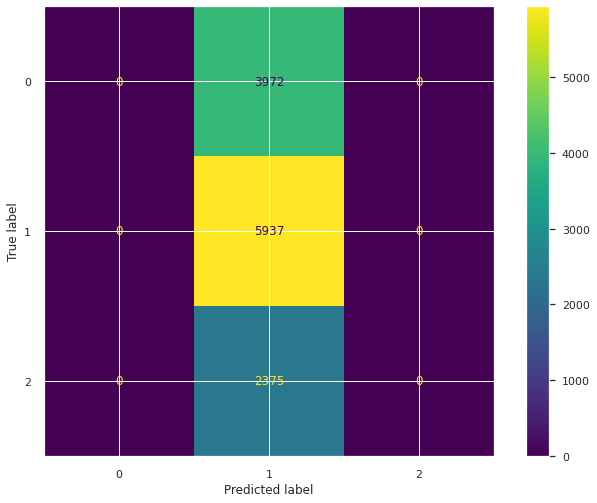

In [185]:
# Train
# The dummy classifier always predicts the 'most frequent' class
baseline = DummyClassifier(strategy='most_frequent')
start_time = time.time()
baseline.fit(x_train_tfidf, y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate
dummy_predictions_train = baseline.predict(x_train_tfidf)
dummy_score = accuracy_score(y_train, dummy_predictions_train)
print("Train accuracy: {:.2f}%".format(dummy_score*100))

dummy_predictions_val = baseline.predict(x_val_tfidf)
dummy_score = accuracy_score(y_val, dummy_predictions_val)
print("Evaluation accuracy: {:.2f}% \n".format(dummy_score*100))

dummy_predictions_test = baseline.predict(x_test_tfidf)
dummy_score = accuracy_score(y_test, dummy_predictions_test)
print("Test accuracy: {:.2f}% \n".format(dummy_score*100))

print('#Class 0 in Train dataset:', np.where(y_train == 0)[0].shape)
print('#Class 1 in Train dataset:', np.where(y_train == 1)[0].shape)

print("\nConfusion Matrix for test data:")
plot_confusion_matrix(estimator=baseline, X=x_test_tfidf, y_true=y_test, values_format = '.0f')

##**LOGISTIC REGRESSION**

Training took: 1.7853443622589111 seconds 

Train f1-score: 73.31% 

Evaluation f1-score: 67.00% 

Test f1-score: 57.86% 


Confusion Matrix for test data:


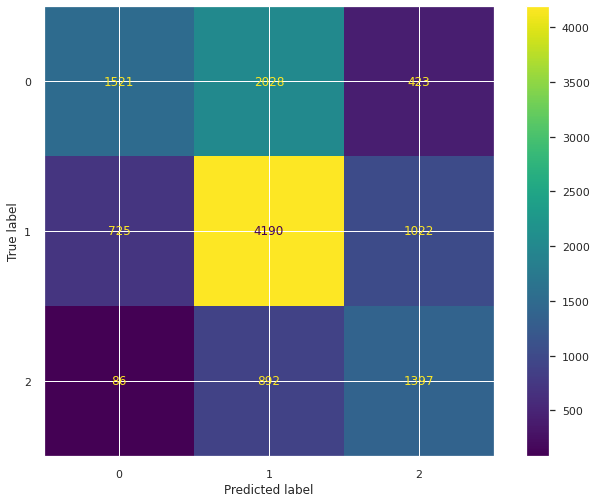

In [186]:
# Train
# Solver -- Algorithm to use in the optimization problem.
lgr = LogisticRegression(multi_class='multinomial', solver='lbfgs', C= 1.0, max_iter = 50)
start_time = time.time()
lgr.fit(x_train_tfidf, y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate
lgr_predictions_train = lgr.predict(x_train_tfidf)
lgr_score = f1_score(y_train, lgr_predictions_train, average='micro')
print("Train f1-score: {:.2f}% \n".format(lgr_score*100))

lgr_predictions_val = lgr.predict(x_val_tfidf)
lgr_score = f1_score(y_val, lgr_predictions_val, average='micro')
print("Evaluation f1-score: {:.2f}% \n".format(lgr_score*100))

lgr_predictions_test = lgr.predict(x_test_tfidf)
lgr_score = f1_score(y_test, lgr_predictions_test, average='micro')
print("Test f1-score: {:.2f}% \n".format(lgr_score*100))

print("\nConfusion Matrix for test data:")
plot_confusion_matrix(estimator=lgr, X=x_test_tfidf, y_true=y_test, values_format='.0f')

##**KNN**

Training took: 0.012373685836791992 seconds 

Train f1-score: 62.81%
Evaluation f1-score: 53.75% 

Test f1-score: 51.04% 


Confusion Matrix for test data:


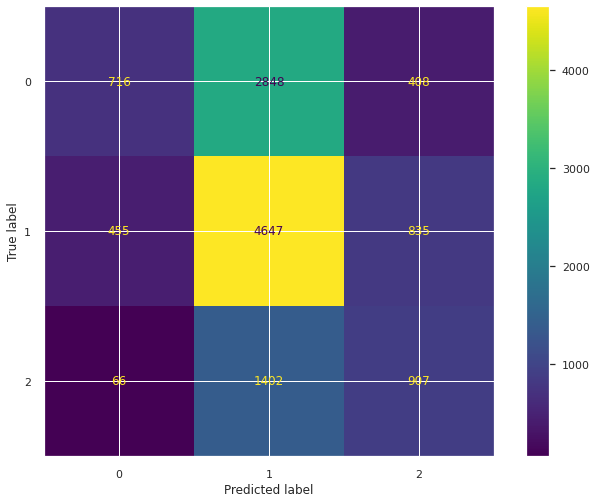

In [187]:
# Train
knn = KNeighborsClassifier(n_neighbors=11, leaf_size = 1, p = 2)
start_time = time.time()
knn.fit(x_train_tfidf, y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate
knn_predictions_train = knn.predict(x_train_tfidf)
knn_score = f1_score(y_train, knn_predictions_train, average = 'micro')
print("Train f1-score: {:.2f}%".format(knn_score*100))

knn_predictions_val = knn.predict(x_val_tfidf)
knn_score = f1_score(y_val, knn_predictions_val, average = 'micro')
print("Evaluation f1-score: {:.2f}% \n".format(knn_score*100))

knn_predictions_test = knn.predict(x_test_tfidf)
knn_score = f1_score(y_test, knn_predictions_test, average = 'micro')
print("Test f1-score: {:.2f}% \n".format(knn_score*100))

print("\nConfusion Matrix for test data:")
plot_confusion_matrix(estimator=knn, X=x_test_tfidf, y_true=y_test, values_format = '.0f')

##Hyper parameter tuning via Grid Search

In [191]:
pipeline1 = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('lr', LogisticRegression())])

pipeline2 = Pipeline([
    ('knn', KNeighborsClassifier()),])

grid_params1 = {
  'tfidf_vectorizer__min_df': np.linspace(0.0001, 0.001, 10),
  'tfidf_vectorizer__ngram_range': [(1,1),(1,2),(1,3)],  
  'tfidf_vectorizer__sublinear_tf': [True,False],
  'lr__solver': ['lbfgs'],
  'lr__C': np.linspace(0.1, 1, 10),
  'lr__max_iter': [50, 100, 200],
}

grid_params2 = {
  'knn__n_neighbors': list(range(1,30)),
  'knn__leaf_size': list(range(1,50)),
}


gs = GridSearchCV(pipeline1, grid_params1, scoring='f1_macro', cv=3, n_jobs=-1)
gs = gs.fit(x_val, y_val)
logistic_score = gs.best_score_
logistic_params = gs.best_params_
print("111111111111")
gs2 = GridSearchCV(pipeline2, grid_params2, scoring='f1_macro', cv=3, n_jobs=-1)
gs2 = gs2.fit(x_val_tfidf, y_val)
knn_score = gs2.best_score_
knn_params = gs2.best_params_

print("Finished Grid Search \n")



print("Best Score of Logistic Regression: ", logistic_score)
print("Best Parameters of Logistic Regression:  \n", logistic_params)

print("Best Score of KNN: ", knn_score)
print("Best Parameters of KNN:  \n", knn_params)

111111111111
Finished Grid Search 

Best Score of Logistic Regression:  0.41043866366287496
Best Parameters of Logistic Regression:  
 {'lr__C': 1.0, 'lr__max_iter': 50, 'lr__solver': 'lbfgs', 'tfidf_vectorizer__min_df': 0.0007999999999999999, 'tfidf_vectorizer__ngram_range': (1, 1), 'tfidf_vectorizer__sublinear_tf': True}
Best Score of KNN:  0.43691054953199066
Best Parameters of KNN:  
 {'knn__leaf_size': 1, 'knn__n_neighbors': 7}


##Time for results! We will compute precision, recall, f1, AUC and more for each classifier.

In [189]:
def calculateResults(x, y, classifier):
  # calculate precision, recall and f1
  train_precision_score = precision_score(y, classifier.predict(x), average=None)
  train_recall_score = recall_score(y, classifier.predict(x), average=None)
  train_f1_score = f1_score(y, classifier.predict(x), average=None)

  # macro precision, recall, f1 and auc
  m_train_precision_score = precision_score(y, classifier.predict(x), average='macro')

  m_train_recall_score = recall_score(y, classifier.predict(x), average='macro')

  m_train_f1_score = f1_score(y, classifier.predict(x), average='macro')

  m_train_roc_auc_score = roc_auc_score(y, classifier.predict_proba(x), multi_class='ovr', average='macro')

  # auc calculation is a bit more messy

  classes = classifier.classes_ # get the classes of the model
  train_roc_auc_score = {}
  for i in range(len(classes)):
      c = classes[i]
    
      # Prepares an auxiliar dataframe to help with the plots
      df_x = pd.DataFrame (x, columns = ['text']) # convert list to a dataframe
      y_proba = classifier.predict_proba(x) # calculate the probabilities
      df_aux = df_x.copy()
      df_aux['class'] = [1 if y == c else 0 for y in y]
      df_aux['prob'] = y_proba[:, i]
      df_aux = df_aux.reset_index(drop = True)
    
      # Calculates the ROC AUC OvR
      train_roc_auc_score[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

  # Create and print the table

  table = [['    ', 'Precision', 'Recall', 'F1', 'AUC', 'Macro-Precision', 'Macro-Recall', 'Macro-F1', 'Macro-AUC'], 
           ['Positive', round(train_precision_score[0], 3), round(train_recall_score[0], 3), round(train_f1_score[0], 3), round(train_roc_auc_score[0], 3), '-', '-', '-', '-'],
           ['Neutral', round(train_precision_score[1], 3), round(train_recall_score[1], 3), round(train_f1_score[1], 3), round(train_roc_auc_score[1], 3), '-', '-', '-', '-'],
           ['Negative', round(train_precision_score[2], 3), round(train_recall_score[2], 3), round(train_f1_score[2], 3), round(train_roc_auc_score[2], 3), '-', '-', '-', '-'],
           ['Total', '-', '-','-','-', round(m_train_precision_score, 3), round(m_train_recall_score, 3), round(m_train_f1_score, 3), round(m_train_roc_auc_score, 3)]]

  print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

print("Dummy Classifier ------------------------------------------------------------------------------------- \n")

print("The training results: \n")
calculateResults(x_train_tfidf, y_train, baseline)

print("The evaluation results: \n")
calculateResults(x_val_tfidf, y_val, baseline)

print("The test results: \n")
calculateResults(x_test_tfidf, y_test, baseline)

print("Logistic Regression  ------------------------------------------------------------------------------------- \n")

print("The training results: \n")
calculateResults(x_train_tfidf, y_train, lgr)

print("The evaluation results: \n")
calculateResults(x_val_tfidf, y_val, lgr)

print("The test results: \n")
calculateResults(x_test_tfidf, y_test, lgr)

print("KNN  ----------------------------------------------------------------------------------------------------- \n")

print("The training results: \n")
calculateResults(x_train_tfidf, y_train, knn)

print("The evaluation results: \n")
calculateResults(x_val_tfidf, y_val, knn)

print("The test results: \n")
calculateResults(x_test_tfidf, y_test, knn)



Dummy Classifier ------------------------------------------------------------------------------------- 

The training results: 

╒══════════╤═════════════╤══════════╤═══════╤═══════╤═══════════════════╤════════════════╤════════════╤═════════════╕
│          │ Precision   │ Recall   │ F1    │ AUC   │ Macro-Precision   │ Macro-Recall   │ Macro-F1   │ Macro-AUC   │
╞══════════╪═════════════╪══════════╪═══════╪═══════╪═══════════════════╪════════════════╪════════════╪═════════════╡
│ Positive │ 0.0         │ 0.0      │ 0.0   │ 0.5   │ -                 │ -              │ -          │ -           │
├──────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ Neutral  │ 0.452       │ 1.0      │ 0.623 │ 0.5   │ -                 │ -              │ -          │ -           │
├──────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ Negative │ 0.0         │ 0.0      │ 0.0   │

##Lastly, we plot the learning curves using Macro-f1.

([3649, 7298, 10947, 14596, 18246],
 [0.5482230501030156,
  0.5582609241285206,
  0.5566115827358997,
  0.5571154204008485,
  0.5555216264029924],
 [0.4495582663303437,
  0.4495582663303437,
  0.4495582663303437,
  0.4495582663303437,
  0.4495582663303437],
 [0.43410880950341135,
  0.43410880950341135,
  0.43410880950341135,
  0.43410880950341135,
  0.43410880950341135])

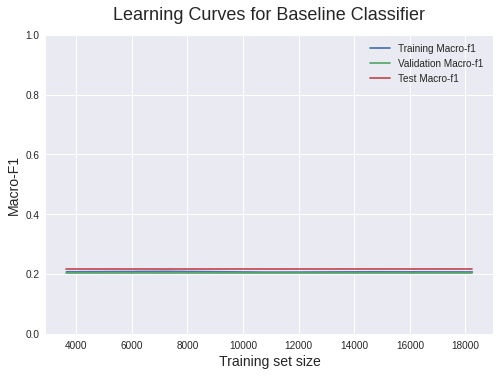

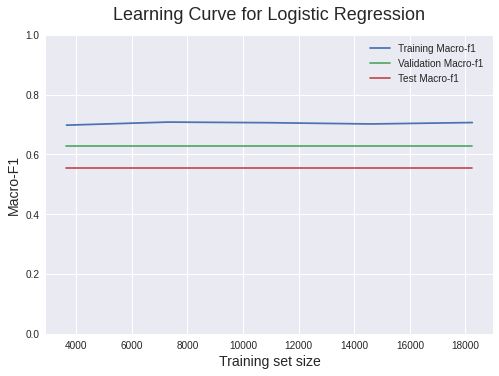

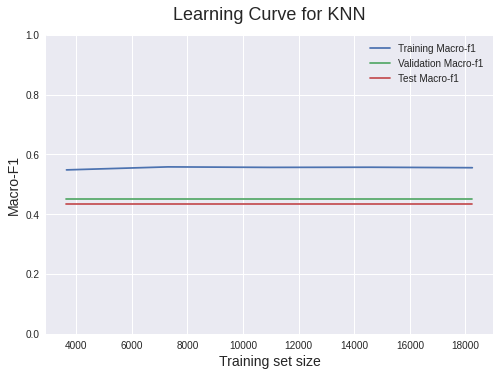

In [190]:
def handleTrainData(x, y, i):
  # We fold the training set manually
  init_size = int(x.shape[0]) # size of the full dataset
  final_size = int(x.shape[0]*(i+1)/10) # size of the data used in this iteration
  peak_number = init_size - final_size - 1 # if the generator picks a number bigger than this then we might get an error due to indexing
  start_index = int(random.randint(0, peak_number)) # the index from which we will start receiving data
  final_index = int(start_index + final_size) # the index that we will stop
  updated_x_train_tfidf = x[start_index:final_index] # transfer the data used in this iteration to another list
  updated_y_train = y[start_index:final_index]

  return updated_x_train_tfidf, updated_y_train, final_size


def drawCurves(x_train, y_train1, x_val, y_val1, x_test, y_test1, k, classifier, title):
  m_train_f1_score = []
  m_val_f1_score = []
  m_test_f1_score = []
  train_sizes = []

  for i in range(k):
    new_x_train, new_y_train, this_size = handleTrainData(x_train, y_train1, i)
    train_sizes.insert(i, this_size)
    m_train_f1_score.insert(i, f1_score(new_y_train, classifier.predict(new_x_train), average='macro'))
    m_val_f1_score.insert(i, f1_score(y_val1, classifier.predict(x_val), average='macro'))
    m_test_f1_score.insert(i, f1_score(y_test1, classifier.predict(x_test), average='macro'))

  plt.style.use('seaborn')
  plt.figure()
  plt.plot(train_sizes, m_train_f1_score, label = 'Training Macro-f1')
  plt.plot(train_sizes, m_val_f1_score, label = 'Validation Macro-f1')
  plt.plot(train_sizes, m_test_f1_score, label = 'Test Macro-f1')
  plt.ylabel('Macro-F1', fontsize = 14)
  plt.xlabel('Training set size', fontsize = 14)
  plt.title(title, fontsize = 18, y = 1.03)
  plt.legend()
  plt.ylim(0,1)

  return train_sizes, m_train_f1_score, m_val_f1_score, m_test_f1_score


drawCurves(x_train_tfidf, y_train, x_val_tfidf, y_val, x_test_tfidf, y_test, 5, baseline, 'Learning Curves for Baseline Classifier')
drawCurves(x_train_tfidf, y_train, x_val_tfidf, y_val, x_test_tfidf, y_test, 5, lgr, 'Learning Curve for Logistic Regression')
drawCurves(x_train_tfidf, y_train, x_val_tfidf, y_val, x_test_tfidf, y_test, 5, knn, 'Learning Curve for KNN')